In [1]:
# IIT =- TrOCR
from transformers import VisionEncoderDecoderModel
from transformers import ViTFeatureExtractor, RobertaTokenizer, TrOCRProcessor
from transformers import VisionEncoderDecoderModel
from transformers import TrOCRProcessor
from PIL import Image


import matplotlib.pyplot as plt
from matplotlib import font_manager as fm


import os
import random

import pandas as pd
import numpy as np

In [2]:
# install required packages
!pip install evaluate
!pip install jiwer




  Using cached jiwer-3.0.4-py3-none-any.whl.metadata (2.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
root_directory = '/content/drive/MyDrive/Sharede/IIT-HW-Hindi_v1/'

In [6]:

os.listdir(root_directory)


['lexicon.txt',
 'Readme.txt',
 'hindi_vocab.txt',
 'test.txt',
 'val.txt',
 'train.txt',
 'HindiSeg.tar.gz',
 'runs',
 'HindiSeg',
 'train_extracted_files.csv',
 'test_extracted_files.csv',
 'val_extracted_files.csv',
 'model',
 'checkpoint-800',
 'checkpoint-1000',
 'checkpoint-1100',
 'checkpoint-1200']

In [7]:
os.chdir(root_directory)

In [8]:
!pwd

/content/drive/MyDrive/Sharede/IIT-HW-Hindi_v1


In [9]:
train_df = pd.read_csv('train_extracted_files.csv')
test_df = pd.read_csv('test_extracted_files.csv')
val_df = pd.read_csv('val_extracted_files.csv')

In [10]:
train_df = train_df.sample(frac=0.1).reset_index(drop=True)
test_df = test_df.sample(frac=0.1).reset_index(drop=True)
val_df = val_df.sample(frac=0.1).reset_index(drop=True)

### Check Loaded DataFrame

In [11]:
# thus the finally obtained DF with valid existing files are in terms of
train_df.head(3)

,Unnamed: 0,file_name,text
0,45032,HindiSeg/train/4/201/26.jpg,अजमेरवासियों
1,49114,HindiSeg/train/2/41/3.jpg,हैसियत
2,34946,HindiSeg/train/1/130/1.jpg,चार-छह


In [12]:
test_df.head(3)


,Unnamed: 0,file_name,text
0,6191,HindiSeg/test/6/69/23.jpg,बाजपेयी
1,5980,HindiSeg/test/9/131/9.jpg,अंकों
2,3434,HindiSeg/test/6/40/2.jpg,मजूरों


In [13]:
val_df.head(3)


,Unnamed: 0,file_name,text
0,425,HindiSeg/val/3/18/16.jpg,सेटेलाइट
1,3584,HindiSeg/val/3/14/23.jpg,मनाया
2,187,HindiSeg/val/12/82/25.jpg,बोरिवली


In [14]:
train_df.shape

(6883, 3)

# DATASET Class


In [15]:

import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
#         print(encoding)
        return encoding

# Load Required Models and initialize tokenizers

In [16]:
from transformers import ViTFeatureExtractor, RobertaTokenizer, TrOCRProcessor, PreTrainedTokenizerFast
from transformers import VisionEncoderDecoderModel
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModelForMaskedLM

encode = 'google/vit-base-patch16-224-in21k'
decode = 'amitness/nepbert'

feature_extractor=ViTFeatureExtractor.from_pretrained(encode)
tokenizer = RobertaTokenizer.from_pretrained(decode)
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
processor = TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)

from transformers import TrOCRProcessor

train_dataset = IAMDataset(root_dir=root_directory ,
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir=root_directory,
                           df=test_df,
                           processor=processor)

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encode, decode)

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
print(processor.tokenizer.pad_token_id)
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# config_decoder.is_decoder = True
# config_decoder.add_cross_attention = True

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 16
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


vocab.json:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/856k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:47: FutureWarning: The `feature_extractor` argument is deprecated and will be removed in v5, use `image_processor` instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/334M [00:00<?, ?B/s]

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at amitness/nepbert and are newly initialized: ['roberta.encoder.layer.0.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.0.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.0.crossattention.output.dense.bias', 'roberta.encoder.layer.0.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.self.key.bias', 'roberta.encoder.layer.0.crossattention.self.key.weight', 'roberta.encoder.layer.0.crossattention.self.query.bias', 'roberta.encoder.layer.0.crossattention.self.query.weight', 'roberta.encoder.layer.0.crossattention.self.value.bias', 'roberta.encoder.layer.0.crossattention.self.value.weight', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.1.crossattention.output.dense.bias', 'roberta.encoder.layer.1.crossattention.output.dense.weight', 'roberta.encoder

1


In [17]:
processor.tokenizer.sep_token_id

2

In [ ]:
tokenizer.tokenize('</s>')



['</s>']

In [ ]:
ids= tokenizer.encode('माम्फुली')

In [ ]:
train_dataset[1]['labels']
labels_ids = train_dataset[2]['labels']
labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id  # Handling padding tokens
processor.batch_decode(ids, skip_special_tokens=True)

['<s>', 'म', 'ा', 'म', '्', 'फ', 'ु', 'ल', 'ी', '</s>']

In [ ]:
model.config.decoder.vocab_size


52000

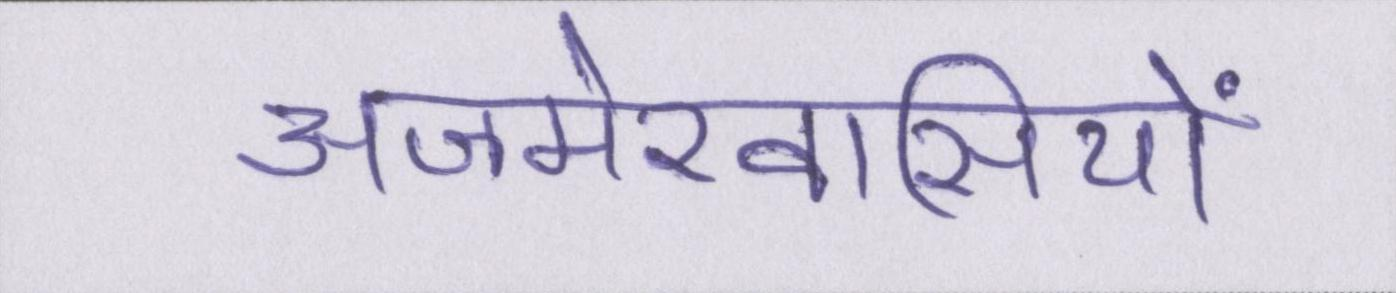

In [18]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

# Evaluate Metric

In [19]:
from evaluate import load

cer_metric = load("cer")

In [20]:
# Function to filter out special tokens and empty strings
def filter_special_tokens(decoded_strs):
    filtered_strs = []
    for s in decoded_strs:
        # Remove special tokens <s>, </s>, and <pad>
        filtered = s.replace(tokenizer.bos_token, "") \
                    .replace(tokenizer.eos_token, "") \
                    .replace(tokenizer.pad_token, "")
        filtered = filtered.strip()  # Remove extra spaces
        if filtered:  # Only include non-empty strings
            filtered_strs.append(filtered)
    return filtered_strs

In [21]:
# Function to pad the shorter list to match the length of the longer one
def pad_to_equal_length(label_str, pred_str):
    max_len = max(len(label_str), len(pred_str))
    # Pad the shorter list with the pad_token to match the length of the longer list
    label_str.extend([tokenizer.pad_token] * (max_len - len(label_str)))
    pred_str.extend([tokenizer.pad_token] * (max_len - len(pred_str)))
    return label_str, pred_str

In [22]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    # Strip unnecessary whitespace that may be introduced after decoding
    pred_str = filter_special_tokens(pred_str)
    label_str = filter_special_tokens(label_str)
    label_str,pred_str = pad_to_equal_length(pred_str,label_str)

    # padd for equal length

    # print('label_string',label_str)
    # print('prediction string',pred_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    return {"cer": cer}

In [23]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments




# Define training arguments
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",  # Evaluate every few steps
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    output_dir=root_directory,  # Output directory to save models
    save_total_limit=1,  # Limit the number of saved checkpoints
    logging_steps=2,  # Log every 2 steps
    save_steps=200,  # Save model every 100 steps
    eval_steps=100,  # Evaluate every 100 steps
    save_strategy="steps",  # Save based on steps
    load_best_model_at_end=True,  # Load the best model at the end
    metric_for_best_model="cer",  # Use CER to evaluate the best model
    greater_is_better=False,  # Lower CER is better, hence set to False

)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
from transformers import default_data_collator


# Instantiate the trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.tokenizer,  # Ensure the correct tokenizer is used
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,

    data_collator=default_data_collator,
)
trainer.train()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss,Validation Loss,Cer
100,3.070000,2.976779,0.979086
200,2.858100,2.714025,0.882774
300,2.660500,2.594876,0.872105
400,2.486900,2.494852,0.876342
500,2.450000,2.408185,0.873575
600,2.325400,2.283165,0.842700
700,2.180000,2.208804,0.850847
800,2.104400,2.161198,0.828676
900,1.587100,2.115201,0.826738
1000,1.745700,2.072546,0.827763


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 16, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (http

TrainOutput(global_step=1293, training_loss=2.2451223315698456, metrics={'train_runtime': 6726.5308, 'train_samples_per_second': 3.07, 'train_steps_per_second': 0.192, 'total_flos': 2.680785274944946e+18, 'train_loss': 2.2451223315698456, 'epoch': 3.0})

In [25]:
# Save the final model
model.save_pretrained(root_directory+'updated_model')
feature_extractor.save_pretrained(root_directory+'updated_model')
tokenizer.save_pretrained(root_directory+'updated_model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 16, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


('/content/drive/MyDrive/Sharede/IIT-HW-Hindi_v1/updated_model/tokenizer_config.json',
 '/content/drive/MyDrive/Sharede/IIT-HW-Hindi_v1/updated_model/special_tokens_map.json',
 '/content/drive/MyDrive/Sharede/IIT-HW-Hindi_v1/updated_model/vocab.json',
 '/content/drive/MyDrive/Sharede/IIT-HW-Hindi_v1/updated_model/merges.txt',
 '/content/drive/MyDrive/Sharede/IIT-HW-Hindi_v1/updated_model/added_tokens.json')

In [26]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
from PIL import Image
import torch

# Define the path to the saved model directory
output_dir = root_directory +'updated_model'

# Load the trained model
model = VisionEncoderDecoderModel.from_pretrained(output_dir)

# Load the processor (feature extractor and tokenizer)
from transformers import ViTFeatureExtractor, RobertaTokenizer, TrOCRProcessor

feature_extractor = ViTFeatureExtractor.from_pretrained(output_dir)
tokenizer = RobertaTokenizer.from_pretrained(output_dir)
processor = TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:47: FutureWarning: The `feature_extractor` argument is deprecated and will be removed in v5, use `image_processor` instead.
  warnings.warn(


In [30]:
# Load and preprocess the image
image_path = '/content/11.jpg'
image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB format

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")


In [31]:
# Put the model in evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    outputs = model.generate(
        pixel_values=inputs['pixel_values'],
        max_length=64,  # Maximum length of generated text
        num_beams=4,  # Number of beams for beam search
        early_stopping=True
    )


In [32]:
# Decode the generated tokens
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Print or process the generated text
print("Generated Text:", generated_text)


Generated Text: निर्देश


In [ ]:
decode


'amitness/nepbert'

In [ ]:
tokenizer

RobertaTokenizer(name_or_path='amitness/nepbert', vocab_size=52000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [ ]:
text ="मेरो नाम केंद्रों <mask> "

NameError: name 'inputs' is not defined

In [ ]:
# Encode the text (convert text to tokens and token IDs)
inputs = tokenizer.encode(text, return_tensors="pt")
print("Encoded:", encoded_input)



Encoded: tensor([[   0,  273,  270,  266,  271,  291,  264,  273,  286, 1099,  284,  265,
          266, 2223,  225,    2]])


In [ ]:
mask_token_index = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]


IndexError: too many indices for tensor of dimension 2

In [ ]:
# Decode the tokens back to text
decoded_output = tokenizer.decode(encoded_input[0])
print("Decoded:", decoded_output)

Decoded: <s>मेरो नाम केंद्रों </s>


In [ ]:
from transformers import RobertaForMaskedLM
model = RobertaForMaskedLM.from_pretrained('amitness/nepbert')

model.safetensors:   0%|          | 0.00/334M [00:00<?, ?B/s]

In [ ]:
import torch

In [ ]:
with torch.no_grad():
    outputs = model(**encoded_input)
    predictions = outputs.logits

TypeError: RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): RobertaIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): RobertaOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
  )
  (lm_head): RobertaLMHead(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (decoder): Linear(in_features=768, out_features=52000, bias=True)
  )
) argument after ** must be a mapping, not Tensor

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

# Load pre-trained NepBERT tokenizer and model for MLM
model_name = "amitness/nepbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

# Define input text with a mask in Nepali
text = "तिमीलाई कस्तो <mask> ma?"

# Encode the text (convert text to token IDs)
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=True)
print("Encoded:", inputs['input_ids'])

# Get the position of the [MASK] token
mask_token_index = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Get the predictions for the masked token
logits = outputs.logits

# Get the top 5 predictions for the masked token
mask_token_logits = logits[0, mask_token_index, :]
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

# Decode the predicted tokens
predicted_tokens = [tokenizer.decode([token]) for token in top_5_tokens]
print(f"Top 5 predictions for the masked token: {predicted_tokens}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Encoded: tensor([[   0,  274,  269,  273,  277,  272,  264,  319,  525,  265,  274,  271,
            4, 4969,   35,    2]])
Top 5 predictions for the masked token: [' छ', '?:', ' contact', ' आउल', ' भय']
